### IMPORTING LIBRARIES
---

In [5]:
import os
import random
import re
import pandas as pd
from PyPDF2 import PdfReader
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import nltk
import numpy as np
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### PDF Text Extraction and Preprocessing
---

In [6]:
# File paths
file_paths = {
    "Dementia": {
        "test": r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\1_nlp_dementia_test.pdf",
        "train": [
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\1a_nlp_dementia_train.pdf",
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\1b_nlp_dementia_train.pdf",
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\1c_nlp_dementia_train.pdf"
        ]
    },
    "Colon Cancer": {
        "test": r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\2_ml_coloncancer_test.pdf",
        "train": [
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\2a_ml_coloncancer_train.pdf",
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\2b_ml_coloncancer_train.pdf",
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\2c_ml_coloncancer_train.pdf"
        ]
    },
    "Alzheimers": {
        "test": r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\3_ml_alzheimers_test.pdf",
        "train": [
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\3a_ml_alzheimers_train.pdf",
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\3b_ml_alzheimers_train.pdf",
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\3c_ml_alzheimers_train.pdf"
        ]
    },
    "Parkinson's": {
        "test": r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\4_ml_parkinson_s_test.pdf",
        "train": [
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\4a_ml_parkinson_s_train.pdf",
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\4b_ml_parkinson_s_train.pdf",
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\4c_ml_parkinson_s_train.pdf"
        ]
    },
    "Depression": {
        "test": r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\5_nlp_depression_test.pdf",
        "train": [
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\5a_nlp_depression_train.pdf",
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\5b_nlp_depression_train.pdf",
            r"C:\Users\karel\OneDrive\Documents\Data science application\Data science data\5c_nlp_depression_train.pdf"
        ]
    }
}

# words to remove
frequent_words = [
    'dementia', 'demented', 'démence', 'alz',
    'colon', 'alzheimers',
    'depression', 'depressed', 'depress', 'parkinsons', 
]

# extract text from PDF
def extract_text_from_pdf(file_path):
    reader = PdfReader(file_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

# clean and preprocess the text
def clean_text(text, lst_stopwords=None, flg_stemm=False, flg_lemm=False):

    #Lowercase the text
    text = text.lower()

    # Remove header/footer patterns
    text = re.sub(r'\b(arxiv\s+\d{4}\.\d{5}v\d|\d+\sof\s\d+|page\s*\d+)\b', ' ', text, flags=re.IGNORECASE)

    #Remove extra numbers and single letters
    text = re.sub(r'\b\d+\b|\b[a-zA-Z]\b', ' ', text)

    # Remove non-alphanumeric characters
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)

    # Remove punctations
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Tokenize the text
    lst_text = text.split()
    
    # Remove stopwords and frequent words
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    lst_text = [word for word in lst_text if word.lower() not in frequent_words]
    
    # Stemming
    if flg_stemm:
        ps = nltk.stem.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    
    # Lemmatization
    if flg_lemm:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    
    # Convert list back to string
    text = " ".join(lst_text)

    # Fix split words
    text = re.sub(r'(?<=[a-z])\s+(?=[a-z])', ' ', text)
    
    return text

### Text Partitioning
---

In [7]:
# Split text into 100-word partitions
def split_into_samples(text, words_per_sample=100):
    words = text.split()
    samples = [" ".join(words[i:i + words_per_sample]) for i in range(0, len(words), words_per_sample)]
    return samples
# Preparing dataset
data = []
for category, files in file_paths.items():
    # Process test set
    test_text = extract_text_from_pdf(files["test"])
    cleaned_test_text = clean_text(test_text)
    test_partitions = split_into_samples(cleaned_test_text)
    data.extend([{"text": partition, "label": category, "set": "test"} for partition in test_partitions])
    
    # Process train sets
    for idx, train_file in enumerate(files["train"]):
        train_text = extract_text_from_pdf(train_file)
        cleaned_train_text = clean_text(train_text)
        train_partitions = split_into_samples(cleaned_train_text)
        data.extend([{"text": partition, "label": category, "set": f"train_{chr(97+idx)}"} for partition in train_partitions])

# Convert to DataFrame
df = pd.DataFrame(data)

# Save to CSV
output_path = r"C:\Users\karel\OneDrive\Documents\cleaned_data.csv"
df.to_csv(output_path, index=False)
print(f"Data saved to {output_path}")

Data saved to C:\Users\karel\OneDrive\Documents\cleaned_data.csv


### Feature Engineering: Label Encoding & Text Vectorization
---

In [8]:
# Labels encoding
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# BOW Transformation
count_vect = CountVectorizer(stop_words='english')
X_train_counts = count_vect.fit_transform(df['text'])

# TF-IDF Transformation
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_tfidf = tf_transformer.transform(X_train_counts) 

# transformed features
print(f"BOW Shape: {X_train_counts.shape}")
print(f"TF-IDF Shape: {X_tfidf.shape}")

BOW Shape: (1434, 16161)
TF-IDF Shape: (1434, 16161)


### Model Training & Evaluation with Cross-Validation
---

In [ ]:
# models
models = {
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(),
    "Naïve Bayes": MultinomialNB(),
    "k-NN": KNeighborsClassifier(),
    "XG-Boost": xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_))
}

# 10-Fold Cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}:")
    scores = cross_val_score(model, X_tfidf, df['label_encoded'], cv=cv, scoring='accuracy')
    print(f"Accuracy scores for 10 folds: {scores}")
    print(f"Mean accuracy: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")



Evaluating SVM:
Accuracy scores for 10 folds: [0.97916667 0.95833333 0.96527778 0.92361111 0.91608392 0.92307692
 0.93006993 0.95804196 0.95104895 0.93706294]
Mean accuracy: 0.9442
Standard deviation: 0.0200

Evaluating Random Forest:
Accuracy scores for 10 folds: [0.92361111 0.90277778 0.88888889 0.875      0.9020979  0.90909091
 0.85314685 0.86713287 0.88111888 0.83916084]
Mean accuracy: 0.8842
Standard deviation: 0.0250

Evaluating Naïve Bayes:
Accuracy scores for 10 folds: [0.79861111 0.77777778 0.81944444 0.77083333 0.67132867 0.78321678
 0.76223776 0.74825175 0.76223776 0.74825175]
Mean accuracy: 0.7642
Standard deviation: 0.0374

Evaluating k-NN:
Accuracy scores for 10 folds: [0.92361111 0.93055556 0.94444444 0.84027778 0.83216783 0.8951049
 0.87412587 0.88811189 0.88811189 0.87412587]
Mean accuracy: 0.8891
Standard deviation: 0.0348


### Error Analysis
---

In [ ]:
#Error Analysis

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df['label_encoded'], test_size=0.2, random_state=42
)

# Model Training
best_model = SVC(kernel='linear')
best_model.fit(X_train, y_train)

# Prediction Function
def predict(text, model, vectorizer, tfidf_transformer):
    text_counts = vectorizer.transform([text])
    text_tfidf = tfidf_transformer.transform(text_counts)
    pred = model.predict(text_tfidf)
    return label_encoder.inverse_transform(pred)[0]

# Prediction on Unseen Data
new_text = "The patient shows cognitive impairment typical of Alzheimer's."
print("\nPrediction:", predict(new_text, best_model, count_vect, tf_transformer))

# Error Analysis on Test Data
y_test_pred = best_model.predict(X_test)
print("\nError Analysis for SVM Model:")
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))




Prediction: Alzheimers

Error Analysis for SVM Model:
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        75
           1       0.98      0.98      0.98        46
           2       0.91      0.89      0.90        35
           3       0.94      0.97      0.95        74
           4       0.98      0.93      0.95        57

    accuracy                           0.95       287
   macro avg       0.95      0.95      0.95       287
weighted avg       0.96      0.95      0.95       287

Confusion Matrix:
 [[73  0  1  1  0]
 [ 1 45  0  0  0]
 [ 2  0 31  2  0]
 [ 0  0  1 72  1]
 [ 0  1  1  2 53]]


### Misclassified samples identification
---

In [41]:
#Error Segment Properties

# Ensure y_test and y_test_pred have the same length
if len(y_test) == len(y_test_pred):
    misclassified_indices = y_test.index[y_test != y_test_pred]
    misclassified_data = df.iloc[misclassified_indices]

    # Display Misclassified Samples
    print("\nMisclassified Samples:")
    for idx in misclassified_indices:
        if idx < len(y_test_pred):  # Check to avoid index out of bounds error
            true_label = label_encoder.inverse_transform([y_test[idx]])[0]
            predicted_label = label_encoder.inverse_transform([y_test_pred[idx]])[0]
            print(f"Text: {df['text'].iloc[idx]}\nTrue Label: {true_label}, Predicted Label: {predicted_label}\n")

    # Group Misclassified Samples by True Label
    print("\nMisclassified Samples Grouped by True Label:")
    print(misclassified_data.groupby('label_encoded').size())
else:
    print("Error: y_test and y_test_pred have different lengths.")



Misclassified Samples:
Text: access this article is licensed under creative commons attribution international license which permits use sharing adaptation distribution and reproduction in any medium or format as long as you give appropriate credit to the original author and the source provide link to the creative commons licence and indicate if changes were made the images or other third party material in this article are included in the article creative commons licence unless indicated otherwise in credit line to the material if material is not included in the article creative commons licence and your intended use is not permitted by statutory regulation or
True Label: Dementia, Predicted Label: Parkinson's

Text: instituteonaging thenationalinstituteofbiomedicalimagingandbioengineering andthroughgenerouscontributionsfromthefollowing abbvie alzheimer sassociation alzheimer sdrugdiscoveryfoundation araclonbiotech bioclinica inc biogen bristol myerssquibbcompany cerespir inc cogstate e

### Visualization: Confusion Matrix
---

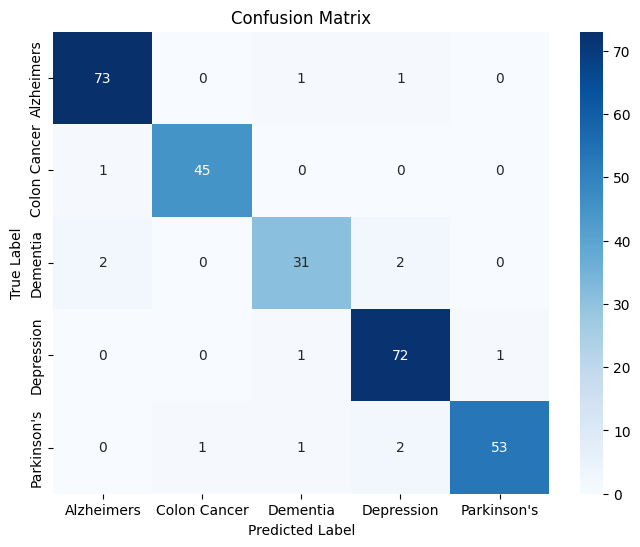

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Visualization: Precision, Recall, and f1-score
---

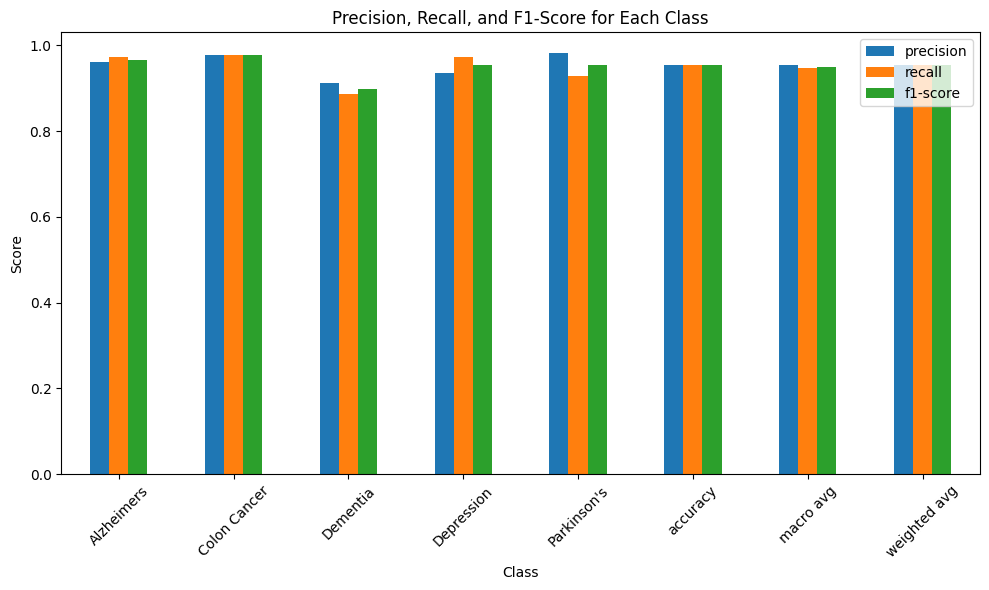

In [43]:
from sklearn.metrics import classification_report
import pandas as pd

# classification report
report = classification_report(y_test, y_test_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot precision, recall, and f1-score for each class
fig, ax = plt.subplots(figsize=(10, 6))
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', ax=ax)
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Visualization: Accuracy
---

C:\Users\karel\AppData\Local\Temp\ipykernel_17784\3026351299.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_encoder.classes_, y=accuracies, palette='Blues')


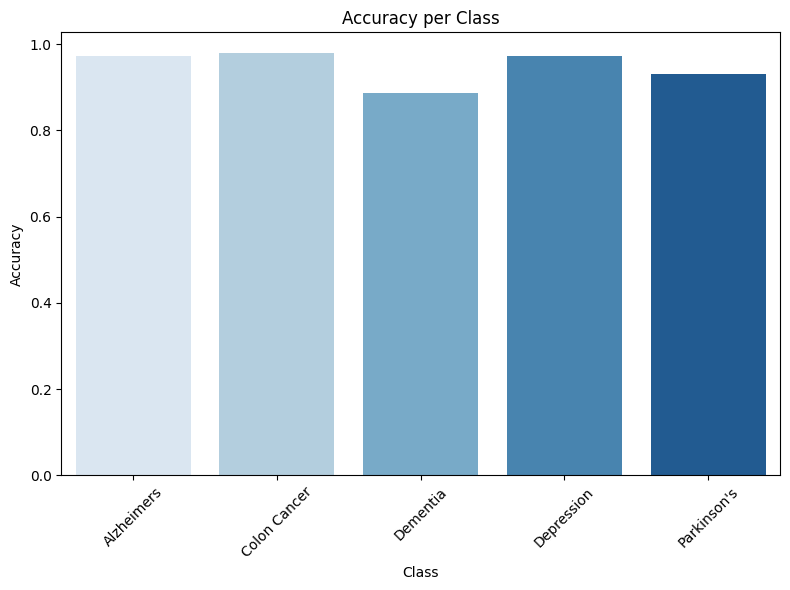

In [44]:
# Accuracy for each class
accuracies = cm.diagonal() / cm.sum(axis=1)

# Plot the accuracies for each class
plt.figure(figsize=(8, 6))
sns.barplot(x=label_encoder.classes_, y=accuracies, palette='Blues')
plt.title('Accuracy per Class')
plt.ylabel('Accuracy')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
!pip freeze > requirements.txt
!dir requirements.txt

 Volume in drive C is Local Disk
 Volume Serial Number is B282-9E7A

 Directory of c:\Users\karel\OneDrive\Documents\Data science application

01/29/2025  01:29 PM               950 requirements.txt
               1 File(s)            950 bytes
               0 Dir(s)  79,382,827,008 bytes free
